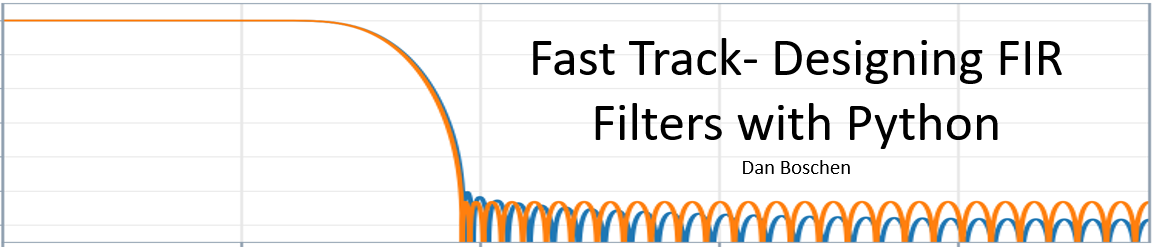

**License** 

Copyright © 2024 C. Daniel Boschen 

This Jupyter Notebook and its associated PDF “Fast Track - Designing FIR Filters with Python” by Dan Boschen is licensed under CC BY-NC-ND 4.0. 

To view a copy of this license, visit https://creativecommons.org/licenses/by-nc-nd/4.0  .  




While every precaution has been taken in the preparation of this notebook, the author, publisher, and distribution partners assume no responsibility for any errors or omissions, or any damages resulting from the use of any informatiocontained within it.




THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE. 

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.fftpack as fft

In [2]:
%matplotlib ipympl

In [3]:
# disable max open figure warning
plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
# Supporting functions

# Dirichlet Kernel

def dirich(w, N):
    # will return the normalized Dirichlet Kernel for w as normalized radian frequency 
    # extending uniquely from -pi to pi
    return 1/N * np.sin(N/2*w)/np.sin(w/2)

def db(x):
    # db of magnitude, excludes divide by zero errors
    mag = np.where(x==0, np.finfo(np.float32).eps, x)
    return 20 * np.log10(np.abs(mag))

# Bottom Line Examples

Quick reminder of the use of the filter design tools for the windowing design and optimized algorithms. These will use the following design targets:

Passband: 0 to .15    (cycles/sample)

Passband ripple: 0.1    (dB)

Stop band: 0.2 to 0.5   (cycles/sample)

Stop band attenuation: 80  (dB)

## Windowing Method 

Estimated number of taps is 102, and estimated Kaiser beta is 7.86


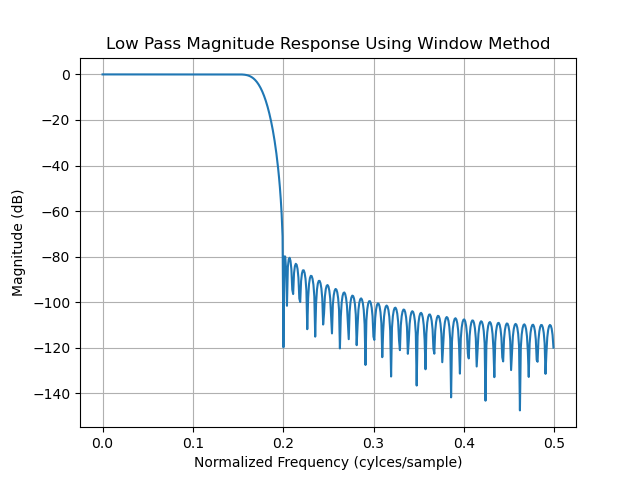

In [5]:
# Requirements   (stopband ripple (attenuation) is more restrictive so used for ripple)
stop_atten = 80
delta_f = 2 * (0.2-0.15)     # normalized such that 1 = Nyquist, or fsamp/2, so multiply by 2 since I am using fsamp=1

# Step1: Use kaiserord to estimate number of taps and beta
numtaps, beta = sig.kaiserord(stop_atten, delta_f)

print(f"Estimated number of taps is {numtaps}, and estimated Kaiser beta is {beta:0.2f}")


# Step2: Use firwin to determine filter coefficients
fco = (0.15 + 0.2)/2    # place 6 dB cutoff midway between pass and stopband
coeff = sig.firwin(numtaps, fco, window=('kaiser', beta), fs=1)


# Step3: Use freqz to review frequency response results compared to requirements
w, h = sig.freqz(coeff)

plt.figure()
plt.plot(w / (2 * np.pi), db(h))
plt.grid()
plt.xlabel("Normalized Frequency (cylces/sample)")
plt.ylabel("Magnitude (dB)")
__=plt.title("Low Pass Magnitude Response Using Window Method")

# Step 4: Modify number of taps, fco, and beta if needed to meet requirements

## Optimized Methods - Least Squares

Estimated number of taps needed using fred harris estimator: 72.7
Estimated number of taps needed using Kaiser estimator: 92.8


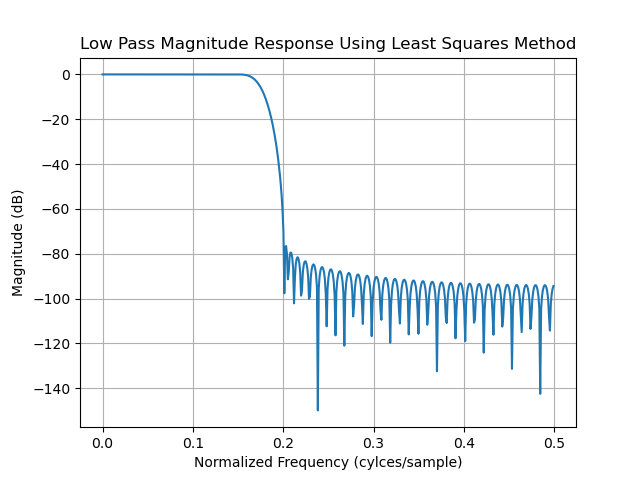

In [6]:
# Requirements:

stop_atten = 80
delta_f  = (0.2-0.15)    # relative to normalized frequency with fsamp = 1

# Step 1: Estimate number of taps needed 

# using fred harris estimator)
ntaps = (stop_atten / 22) / delta_f

# using Kaiser estimator 
delta1 = 10**(.1/20)-1           
delta2 = 10**(-stop_atten/20)
# since delta1 >> delta2, use delta2 for both to have an improved estimate
delta1 = delta2
ntaps2 = (-10*np.log10(delta1 * delta2)-13)/(14.6 * delta_f) + 1   

print(f"Estimated number of taps needed using fred harris estimator: {ntaps:0.1f}")
print(f"Estimated number of taps needed using Kaiser estimator: {ntaps2:0.1f}")
ntaps = 95   # must be odd, increased to meet requirements

# Step 2: Determine coefficients using firls

freqs  = [0, .15, .2, 0.5]
mags = [1, 1, 0, 0]
coeff = sig.firls(ntaps, freqs, mags, fs=1)

# Step 3:  Use freqz to review frequency response results compared to requirements
w, h = sig.freqz(coeff)

plt.figure()
plt.plot(w / (2 * np.pi), db(h))
plt.grid()
plt.xlabel("Normalized Frequency (cylces/sample)")
plt.ylabel("Magnitude (dB)")
__=plt.title("Low Pass Magnitude Response Using Least Squares Method")

# Step 4: Modify number of taps if needed to meet requirements

## Optimized Methods - Equiripple

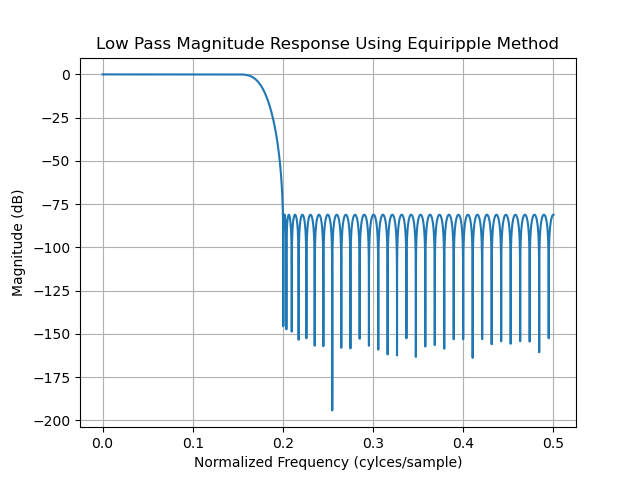

In [7]:
# Step 1: Estimate number of taps
# (used same estimation as in Least Squares above)

# Step 2: Determine coefficients using remez

freqs  = [0, .15, .2, 0.5]
mags = [1, 0]      # note that Python remez command using one magnitude for each freq range
coeff = sig.remez(ntaps, freqs, mags, fs=1)

# Step 3:  Use freqz to review frequency response results compared to requirements
w, h = sig.freqz(coeff, worN= 2**18)

plt.figure()
plt.plot(w / (2 * np.pi), db(h))
plt.grid()
plt.xlabel("Normalized Frequency (cylces/sample)")
plt.ylabel("Magnitude (dB)")
__=plt.title("Low Pass Magnitude Response Using Equiripple Method")



# Step 4: Modify number of taps if needed to meet requirements


# Impulse Responses for Ideal Filters

In [8]:
# Impulse responses

def lowpass(fc, N):
    # fc: frequency cutoff between 0 and 0.5 (normalized frequency with fs=1)
    # N: Number of coefficients, can be even or odd
    n = np.arange(-(N-1)/2,(N-1)/2 + 1)
    return 2 * fc * np.sinc(2*fc*n)

def highpass(fc, N):
    # fc: frequency cutoff between 0 and 0.5 (normalized frequency with fs=1)
    # N: Number of coefficients, must be odd only for symmetric type 1 filter
    if N%2-1:
        #even
        raise ValueError("N must be odd")
    n = np.arange(-(N-1)/2,(N-1)/2 + 1)
    return lowpass(0.5-fc, N) * (-1)**n

def bandpass(f1, f2, N):
    # f1: frequency cutoff between 0 and 0.5 of lower cutoff (normalized frequency with fs=1)
    # f2: frequency cutoff between 0 and 0.5 of upper cutoff (normalized frequency with fs=1)
    # N: Number of coefficients
    n = np.arange(-(N-1)/2,(N-1)/2 + 1)
    return 2 * f2 * np.sinc(2*f2*n) - 2 * f1 * np.sinc(2*f1*n)

def bandstop(f1, f2, N):
    # f1: frequency cutoff between 0 and 0.5 of lower cutoff (normalized frequency with fs=1)
    # f2: frequency cutoff between 0 and 0.5 of upper cutoff (normalized frequency with fs=1)
    # N: Number of coefficients, must be odd only
    if N%2-1:
        #even
        raise ValueError("N must be odd")
    n = np.arange(-(N-1)/2,(N-1)/2 + 1)
    return np.where(n==0, 1- 2 * (f2 - f1), 2*f1 * np.sinc(2*f1*n)  - 2*f2 * np.sinc(2*f2*n))

The plots below demonstrate the ideal impulse response and resulting frequency response for the four filter prototypes: lowpass, highpass, bandpass and bandstop. We see the result here of direct truncation of these ideal impulse responses. The approach with the windowing method of filter design is to then window the ideal impulse response to the desired filter length (number of coefficients) with a higher performance window, resulting in the final filter coefficients to use. 

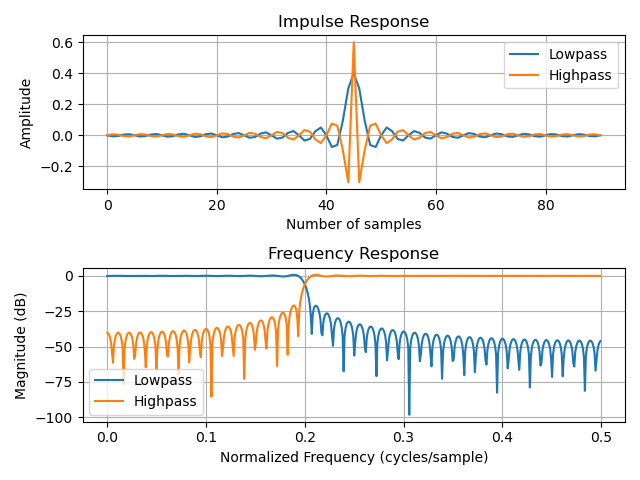

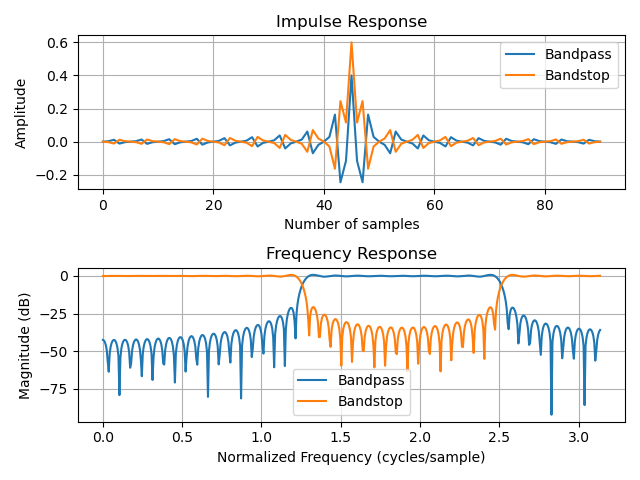

In [9]:
N =91
fc = 0.2
f1 = 0.2
f2 = 0.4

plt.figure()
plt.subplot(2,1,1)
plt.title("Impulse Response")
plt.plot(lowpass(fc, N), label="Lowpass")
plt.plot(highpass(fc, N), label="Highpass")
plt.xlabel("Number of samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()

plt.subplot(2,1,2)
wlp, hlp = sig.freqz(lowpass(fc, N))
whp, hhp = sig.freqz(highpass(fc, N))
plt.title("Frequency Response")
plt.plot(wlp/(2*np.pi), db(hlp), label="Lowpass")
plt.plot(whp/(2*np.pi), db(hhp), label="Highpass")
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid()
plt.tight_layout()

plt.figure()
plt.subplot(2,1,1)
plt.title("Impulse Response")
plt.plot(bandpass(f1,f2,N), label="Bandpass")
plt.plot(bandstop(f1,f2,N), label="Bandstop")
plt.xlabel("Number of samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()

plt.subplot(2,1,2)
wbs, hbs = sig.freqz(bandstop(f1,f2, N))
wbp, hbp = sig.freqz(bandpass(f1,f2, N))
plt.title("Frequency Response")
plt.plot(wbp, db(hbp), label="Bandpass")
plt.plot(wbs, db(hbs), label="Bandstop")
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid()
plt.tight_layout()

# Windowing Method for FIR Design

The windowing method is to select a finite portion of the ideal infinite duration impulse response using a window to taper the edges of the impulse response such as to miminize spectral leakage, resulting in superior stopband rejection and passband ripple at the expense of an increase in the transition band (which is always a good trade; the overall length can be increased to achieve the transition band desired, but without additional windowing, many stopband requirements cannot be practically met.

Note this can be done using the impulse response functions above, or directly using scipy.firwin and scipy.firwin2. 

This method is computationally cheap, and with a Kaiser window comes close to the performance of a filter designed with the optimized Least Squares algorithm (see direct comparison below). Typically, the least squares algorithm would be used when resources for computing the filter coefficients are not an issue. However, this approach is to be considered when filter coefficients are dynamically determined, or in conditions when the least squares algorithm has difficulty converging. 

The following demonstrates the Windowing Method for a low pass filter with the following requirements:

* Passband ripple: ±0.2 dB
* Stopband rejection: -33 dB
* Sampling rate: 48 KHz
* Passband edge: 9.6 KHz
* Stopband edge: 12 KHz


In [10]:
pass_ripp = 0.2        # passband ripple [+/- dB]
stop_rej = -33         # stopband rejection [dB]
fsamp = 48e3              # sampling rate [Hz]
passband = 9600        # passband edge [Hz]
stopband = 12000       # stopband edge [Hz]

fpass = passband/fsamp    # normalized passband frequency [cycles/sample]
fstop = stopband/fsamp    # normalized stopband frequency [cylces/sample]


# Estimating number of taps needed and window beta using the built-in kaiserord function
# Note that kaiserord function wants input frequencies normalized to Nyquist (fsamp/2 = 1)

# Use more restrictive between pass_rip and stop_rej 
delta1 = 10**(pass_ripp/20)-1
delta2 = 10**(stop_rej/20)
print(f"Passband ripple is {delta1:0.3f} and stopband ripple is {delta2:0.3f}")
if delta1 > delta2:
    ripple = -db(delta2)
    print("Using stopband ripple as ripple requirement.")
else:
    ripple = -db(delta1)
    print("Using passband ripple as ripple requirement.")

# (Ripple is a positve dB number)
numtaps, beta = sig.kaiserord(ripple, 2*(fstop-fpass))

print(f"Estimated number of coefficients required: {numtaps:d}")
print(f"Estimated Kaiser window beta required: {beta:0.2f}")

Passband ripple is 0.023 and stopband ripple is 0.022
Using stopband ripple as ripple requirement.
Estimated number of coefficients required: 36
Estimated Kaiser window beta required: 2.52


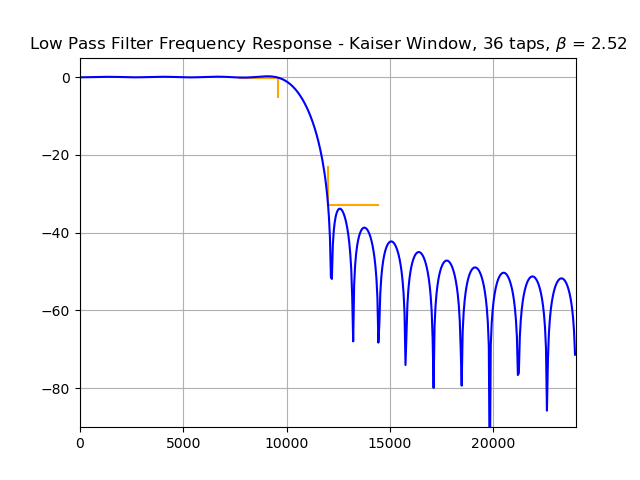

In [11]:
# First we will demonstrate window method directly as a windowed ideal impulse response
# and then we will compare to uisng the firwin command directly


# create ideal impulse response, 

# compute target 6 dB cutoff: (place midway between passband and stopband)
fco = (fpass + fstop)/2

impulse_response = lowpass(fco, numtaps)

# multiply with a Kaiser window
coeff = impulse_response * sig.windows.kaiser(numtaps, beta)

# plot spectrum (made a function as will do this repetitively)

def plotfilt(coeff, passband, stopband, pass_ripp, stop_rej, label="", color='blue'):
    w, h = sig.freqz(coeff)

    # plot requirement markers
    plt.plot([stopband, stopband*1.2], [stop_rej, stop_rej], color='orange')
    plt.plot([stopband, stopband], [stop_rej, stop_rej+10], color='orange')
    plt.plot([passband*.8, passband], [-pass_ripp, -pass_ripp], color='orange')
    plt.plot([passband, passband], [-pass_ripp, -pass_ripp-5], color='orange')
    # plot response
    plt.plot(w * fsamp/(2*np.pi), db(h), label=label, color=color)
    plt.grid()
    
plt.figure()
plotfilt(coeff, passband, stopband, pass_ripp, stop_rej)
plt.axis([0, fsamp/2, -90,5])
__=plt.title(fr"Low Pass Filter Frequency Response - Kaiser Window, {numtaps} taps, $\beta$ = {beta:0.2f}")


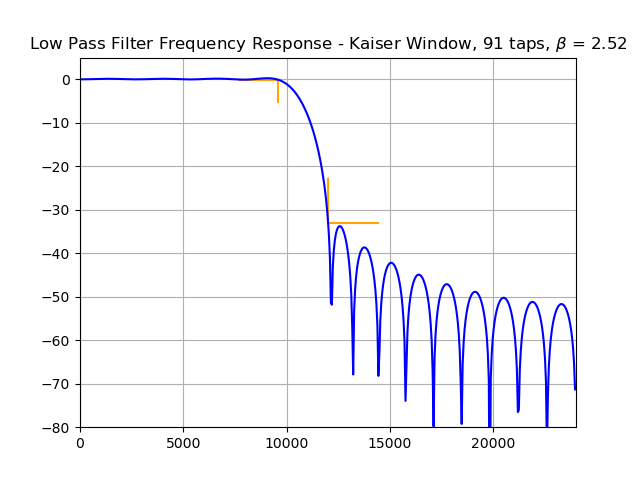

In [12]:
# Showing that firwin returns the same result as windowing the impulse response with the kaiser window:
# (Note that we again increase the passband by approx 12.5% for this case, otherwise passband will be the 
# -6 dB cutoff frequency)
# fco * fsamp since this function is taking freq in Hz given fs=fsamp, and fco is in normalized freq units of cycles/sample
coeff2 = sig.firwin(numtaps, fco * fsamp, window=('kaiser', beta), fs=fsamp)

plt.figure()
plotfilt(coeff2, passband, stopband, pass_ripp, stop_rej)
plt.axis([0, fsamp/2, -80,5])
__=plt.title(fr"Low Pass Filter Frequency Response - Kaiser Window, {N} taps, $\beta$ = {beta:0.2f}")


# Frequency Sampling

"Frequency Sampling" should only be considered in applications where the response at the specific frequency samples as described in a DFT (samples spaced at $f_{samp}/N) are the only concern as this approach will lead to more ripple (error) for the frequencies in between versus the otehr approaches given (windowing and optimized filter design algorithms).  This section creates the graphic in the presentation comparing the impulse and frequency responses to a truncated true Sinc impulse response versus the inverse FFT as used in the frequency sampling method (which is the Dirichlet Kernel or an aliased Sinc function).

fc=0.20495049504950497


(0.0, 0.5, -2.0, 2.0)

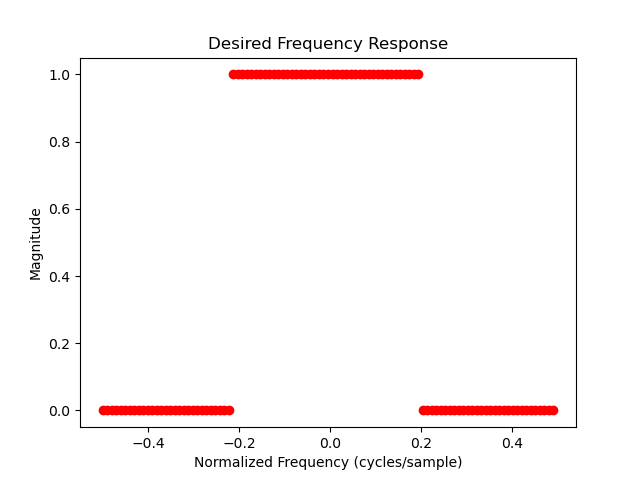

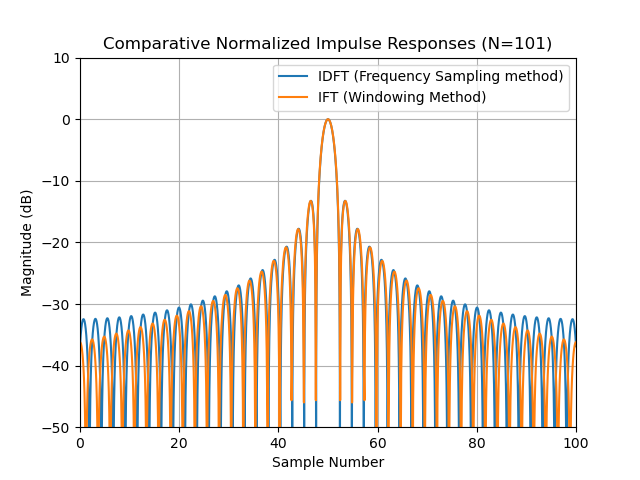

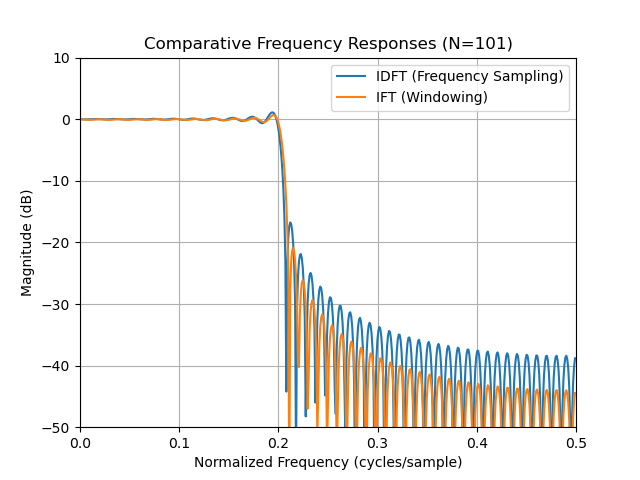

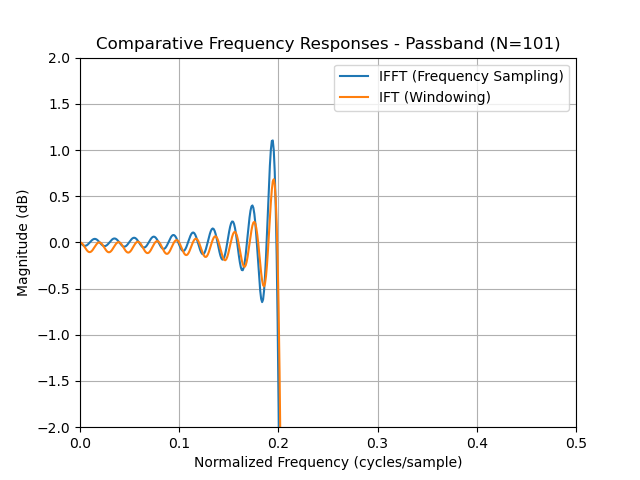

In [13]:
# Dirichlet Kernel vs Sinc Function 
# (showing aliasing and compares the Inverse FT to the Inverse DFT for a rectangular function)

fs = 1
fp = 0.2
N = 101  # keep odd
worN = 10000

# fc is midway (-6 dB) between passband and cutoff. Since the transition band is 1/N, we will set fc to be
# 1/(2N) higher than fp

fc= fp + 1/(2*N)
print(f"{fc=}")

# ideal response
resp = np.zeros(N)
nsamps =int(fc * (N-1)+1)   # added +1 to align passband
resp[:nsamps] = 1
resp[-nsamps:] = 1

# need to center in spectrum as otherwise will become two pulses when zero-padded
#resp[int((N-1)/2-nsamps): int((N-1)/2+nsamps-1)] = 1
resp2 = fft.fftshift(resp)

plt.figure()
plt.title("Desired Frequency Response")
plt.plot(np.arange(N)/N-.5, resp2, 'ro')
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude")

plt.figure()
normalize = worN/(N*np.mean(resp2))
# note the zero padding will add a phase shift, only using here to plot the continuous
# impulse response for reference- so will use abs())
imp_response_freq_samp = fft.fftshift(normalize*fft.ifft(resp2, worN))
coeff_freq_samp = 1/np.mean(resp)* fft.ifftshift(fft.ifft(resp))
nindex = (N) * np.arange(worN)/worN - 1/2

plt.plot(nindex, db(imp_response_freq_samp), label = "IDFT (Frequency Sampling method)")
#plt.plot(db(coeff_freq_samp),'ro')   # to confirm proper samples selected, disable normally from plotting

#impulse response derived from Sinc (as would be done in Windowing approach)

# desired impulse response for brickwall filter (Sinc function):
n = np.linspace(-(N-1)/2, (N-1)/2, 1000, endpoint= True)  
impulse_ift = np.sinc(2*fc*n)    # this will return the underlying continuous-time impulse
                                 # response that would be sampled when n is an integer 
                                 # scaling of 2 * fc was omitted to normalize max value to be 1

coeff_ift = lowpass(fc, N)    # actual samples of the Sinc function for the filter coefficients
plt.plot(n+(N-1)/2, db(impulse_ift), label = "IFT (Windowing Method)")

plt.grid()
plt.title("Impulse Response (Sinc function)")
plt.xlabel("Sample Number")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.axis([0,100, -50, 10])
plt.title("Comparative Normalized Impulse Responses (N=101)")



w1, h1 = sig.freqz(coeff_freq_samp, fs=1)
w2, h2 = sig.freqz(coeff_ift, fs=1)

#normalize each to DC level
h1 = h1/h1[0]
h2 = h2/h2[0]

plt.figure()

plt.plot(w1, db(h1), label = "IDFT (Frequency Sampling)")
plt.plot(w2, db(h2), label = "IFT (Windowing)")
plt.title("Comparative Frequency Responses (N=101)")
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.axis([0,0.5, -50, 10])
plt.legend()
plt.grid()
plt.figure()
plt.plot(w1, db(h1), label = "IFFT (Frequency Sampling)")
plt.plot(w2, db(h2), label = "IFT (Windowing)")
plt.title("Comparative Frequency Responses - Passband (N=101)")
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.legend()
plt.axis([0,0.5, -2, 2])

# Optimized Filter Design Algorithms

The optimized algorithms are superior to window design approaches for achieving minimum error with the least number of coefficients. For an optimum solution in the minimax sense (minimize the peak error), we will use the **scipy.signal.remez** function for the Parks-McClellan filter design algorithm (which used the Remez exchange algorithm specific to filter design). For an optimum solution in the least squares sense we will use the **scipy.signal.firls** function. These will then be compared to the Kaiser Window result above with the least number of taps to meet the design requirement.   

In [14]:
# Estimating the number of taps using fred harris' estimator:

ntaps = -stop_rej / (22 * (fstop-fpass))
print(f"Estimated number of coefficients required using fred harris estimator: {int(ntaps):d}")

Estimated number of coefficients required using fred harris estimator: 30


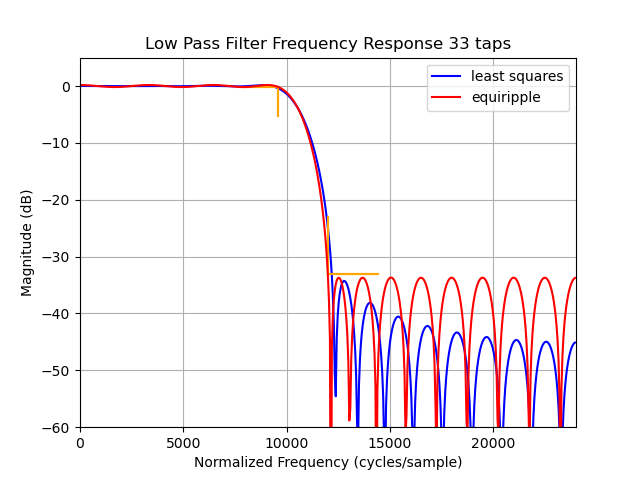

In [15]:
# the firls function requires N to be odd, so increased to next odd number that met target requirement
ntaps = 33
# by setting the optional fsamp we can pass in actual instead of normalized frequency:
coeff_ls = sig.firls(ntaps, [0, passband, stopband, fsamp/2], [1,1,0,0], fs=fsamp)
coeff_pm = sig.remez(ntaps, [0, passband, stopband, fsamp/2], [1, 0] , fs=fsamp)
plt.figure()
plotfilt(coeff_ls, passband, stopband, pass_ripp, stop_rej, label="least squares", color="blue")
plotfilt(coeff_pm, passband, stopband, pass_ripp, stop_rej, label="equiripple", color="red")

plt.axis([0, fsamp/2, -60,5])
plt.grid()
__=plt.title(fr"Low Pass Filter Frequency Response {ntaps} taps")
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.legend()

# Comparison Plot


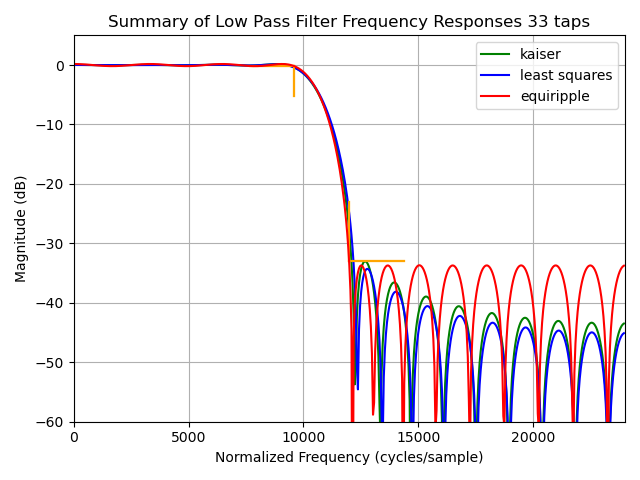

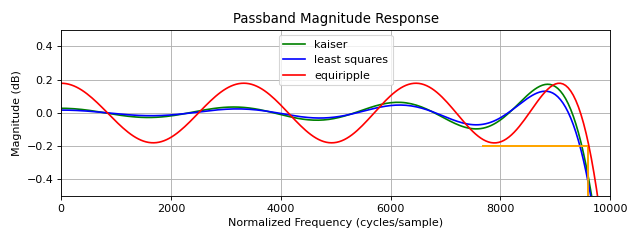

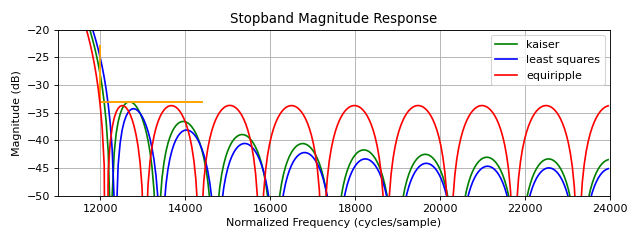

In [16]:
# create Kaiser windowed filter with same number of taps for direct comparison:

coeff_kais = sig.firwin(ntaps, fco * fsamp, window=('kaiser', beta), scale=False, fs=fsamp)

plt.figure()
plotfilt(coeff_kais, passband, stopband, pass_ripp, stop_rej, label="kaiser", color="green")
plotfilt(coeff_ls, passband, stopband, pass_ripp, stop_rej, label="least squares", color="blue")
plotfilt(coeff_pm, passband, stopband, pass_ripp, stop_rej, label="equiripple", color="red")

plt.axis([0, fsamp/2, -60,5])
plt.grid()
__=plt.title(fr"Summary of Low Pass Filter Frequency Responses {ntaps} taps")
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure(figsize=(8, 3), dpi=80)
plotfilt(coeff_kais, passband, stopband, pass_ripp, stop_rej, label="kaiser", color="green")
plotfilt(coeff_ls, passband, stopband, pass_ripp, stop_rej, label="least squares", color="blue")
plotfilt(coeff_pm, passband, stopband, pass_ripp, stop_rej, label="equiripple", color="red")

plt.axis([0, fsamp/2, -60,5])
plt.grid()
__=plt.title("Passband Magnitude Response")
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.axis([0, 10000, -.5,.5])
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure(figsize=(8, 3), dpi=80)
plotfilt(coeff_kais, passband, stopband, pass_ripp, stop_rej, label="kaiser", color="green")
plotfilt(coeff_ls, passband, stopband, pass_ripp, stop_rej, label="least squares", color="blue")
plotfilt(coeff_pm, passband, stopband, pass_ripp, stop_rej, label="equiripple", color="red")

plt.axis([0, fsamp/2, -60,5])
plt.grid()
__=plt.title("Stopband Magnitude Response")
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.axis([11000, 24000, -50,-20])
plt.grid()
plt.legend()
plt.tight_layout()

# Multiband, Highpass, Bandpass Filters

The windowing function scipy.signal.firwin, and the optimized functions scipy.signal.remez and sciply.signal.firls support multiband, highpass and bandpass filter designs. The windowing function scipy.signal.firwin2 allows for varying levels in each of the bands. The following compares these functions with multiband filters. 

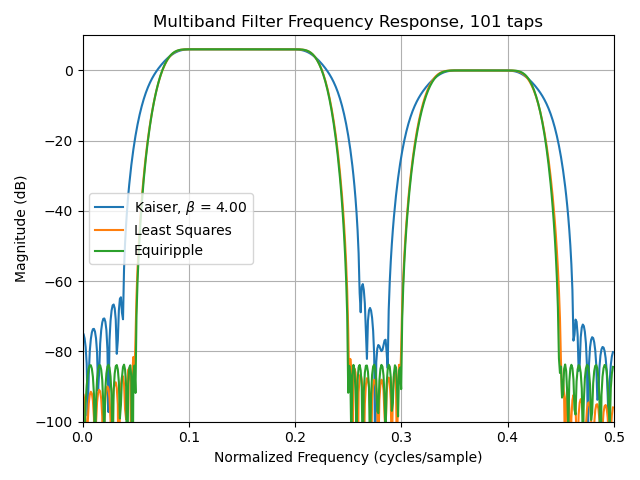

In [17]:
# multiband
# stopband1: f = 0 to 0.05, level = 0
# passband1: f = 0.1 to 0.2, level = 2
# stopband2: f = 0.25 to 0.3, level= 0
# passband2: f = 0.35 to .4 level = 1
# stopband3: f = 0.45 to 0.5 level = 0


numtaps = 101
freqs = [0, .05, .1, .2, .25, .3, .35, .4, .45, .5]
gains = [0, 0, 2, 2, 0, 0, 1, 1, 0, 0]

# kaiser window filter
beta = 4
# extend frequencies corners by 1/numtaps:
ext = 1/numtaps
freqks = [0, .05, .1-ext, 0.2+ext, .25, .3, .35-ext, .4+ext, .45, .5]
coeff_kaiser = sig.firwin2(numtaps, freqks, gains, window=('kaiser', beta), fs = 1)

# least squares filter
coeff_ls = sig.firls(numtaps, freqs, gains, fs = 1)

# equiripple filter
coeff_rm = sig.remez(numtaps, freqs, [0,2,0,1,0], fs = 1)

# plot responses
wk, hk = sig.freqz(coeff_kaiser)
wls, hls = sig.freqz(coeff_ls)
wrm, hrm = sig.freqz(coeff_rm)



plt.figure()
plt.plot(wk/(2*np.pi), db(hk), label= fr"Kaiser, $\beta$ = {beta:0.2f}")
plt.plot(wls/(2*np.pi), db(hls), label= fr"Least Squares")
plt.plot(wrm/(2*np.pi), db(hrm), label= fr"Equiripple")
plt.grid()
plt.axis([0, 1/2, -100,10])
__=plt.title(fr"Multiband Filter Frequency Response, {N} taps")
plt.xlabel("Normalized Frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.tight_layout()

# Arbitrary Magnitude and Phase

The following demonstrates how to use the Inverse FFT to design FIR filters while minimizing the time domain aliasing effects that cause the greater errors used above.

**Is this Freq Sampling or Windowing?**

The process appears to be "Frequency Sampling" but I distinguish this as the Windowing Technique: with the windowing technique we need the best estimate of the filter's sampled impulse response, free of aliasing effects. Once we have that, by any means, we then truncate and window to create the filter. So below we use an inverse FFT of the desired frequency response with a much denser frequency grid (oversampled in the frequency domain), which is the equivalent of stretching out time, minimizing the time domain aliasing! So here we use the IFFT to create a more accurate representation of the true impulse response needed, in contrast to taking an N sample IFFT for an N sample FIR filter which is what I refer to as the "Frequency Sampling Method" specifically.

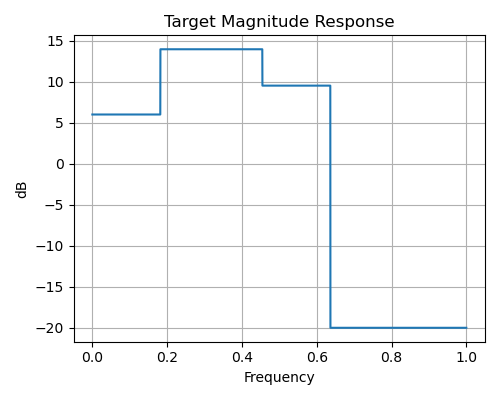

In [18]:
# arbitrary multilevel target frequency response:

fmag = np.concatenate((2*np.ones(1000), 5*np.ones(1500), 3*np.ones(1000), 0.1*np.ones(2000)))

freq_axis = np.arange(len(fmag))/len(fmag) 
plt.figure(figsize=(5,4))
plt.plot(freq_axis, db(fmag))
plt.title("Target Magnitude Response")
plt.xlabel("Frequency")
plt.ylabel("dB")
plt.grid()
plt.tight_layout();



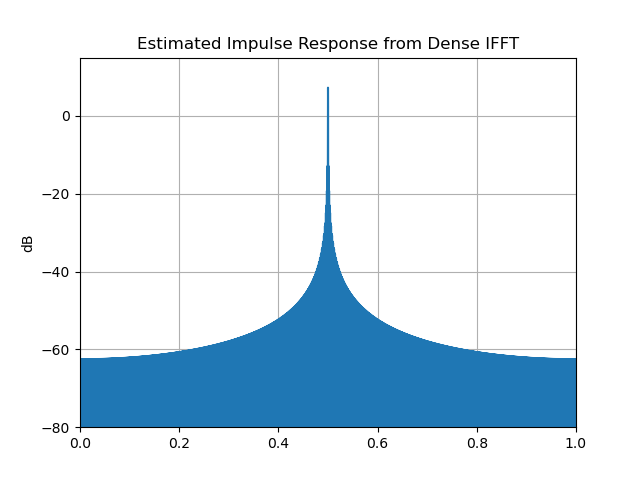

In [19]:
# impulse response

impulse_response = fft.fftshift(fft.ifft(fmag))
time_axis = np.arange(len(impulse_response ))/len(impulse_response ) 
plt.figure()
plt.plot(time_axis, db(np.abs(impulse_response)))
plt.ylabel('dB')
plt.axis([0, 1, -80, 15])
plt.title("Estimated Impulse Response from Dense IFFT")
plt.grid()

Filter Length = 549 Taps


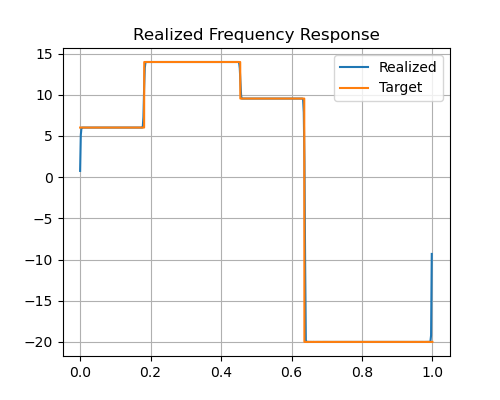

In [20]:
# truncate and window

coeff = impulse_response[(time_axis > 0.45) & (time_axis < 0.55)]
print(f"Filter Length = {len(coeff)} Taps")
#window
coeff = coeff*sig.windows.kaiser(len(coeff), 8)

w, h = sig.freqz(coeff, whole=True)

plt.figure(figsize=(5,4))
plt.plot(w/(2*np.pi), 20*np.log10(np.abs(h)), label="Realized")
plt.plot(freq_axis, db(fmag), label = "Target")
plt.title("Realized Frequency Response")
plt.grid()
plt.legend();